# **Batch Size Result Visualization**

The previously analyzed data is here used to visualize the results in various figures. Individual models be visualized in barplots, while all considered models are shown through line-plots (also divided between lighter and heavier models, to improve visualization of the data).

In [225]:
# import required libraries
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import textwrap
import glasbey
import os

In [ ]:
# get working directory, necessary to gather the data to be analyzed
current_dir = os.getcwd()
print(f"Current Working Directory: {current_dir}")
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(f"Parent Directory: {parent_dir}")

## **Helper Functions**
Useful functions to properly format labels and visualize plots correctly.

In [227]:
def plot_batch_exp(mdl, option="summary", compare=True):
    """
    Visualize and compare variable batch size emission experiment results.

    Processes emission data for a specified model or compares multiple models across various batch sizes.
    It generates either line or bar plots depending on the `compare` flag and the available data.

    Parameters:
    -----------
    mdl : str or list[str]
        Name(s) of the model(s) to analyze. If comparing, pass a list of model names.

    option : str, optional (default="summary")
        Metric to visualize. Allowed values:

        - "energy_consumed": Total energy consumed by the models.
        - "emissions": Total emissions (in CO₂-equivalents).
        - "emissions_rate": Emission rate during experiments.
        - "summary": Generate plots for all metrics.

    compare : bool, optional (default=True)
        If True, compares emission data across multiple models. If False, focuses on a single model.

    Returns:
    --------
    None
        Saves the generated plots as PNG files and displays them.
    """
    # Initialize the summary flag to control metric analysis
    summary = False  # Controls whether to visualize all metrics or a specific one

    fontdim = 16; out = "pdf"
    size = (10, 5)

    # Dictionary mapping metrics to their plotting properties
    emissdict = {"gpu_energy": ["gpu_energy", "rocket_r", "Energy at inference (GPU)", "[kWh]", "Energy at inference"],
                 "emissions": ["emissions", "crest", "Total Emissions", "[Kg]", "Emissions in CO$_2$-eq"]}

    batches = [
        {"path": path + r"batch1\total.csv", "std_path": path + r"batch1\total_std.csv", "label": f"1"},
        {"path": path + r"batch2\total.csv", "std_path": path + r"batch2\total_std.csv", "label": f"2"},
        {"path": path + r"batch5\total.csv", "std_path": path + r"batch5\total_std.csv", "label": f"5"},
        {"path": path + "averaged_batch10.csv", "std_path": path + "std_batch10.csv", "label": f"10"}
    ]

    # Iterate over emission metrics
    for i, p in enumerate(emissdict.keys()):
        if option == "summary":
            summary = True

        # Skip other metrics if not in summary mode
        if not summary and i != 0:
            continue
        elif summary:
            option = p

        all_batches = []
        all_stds = []

        if compare:
            # Prepare containers for comparison across models
            all_data = [[], []]  # [mean data, std data]
            for patho in path_list:
                batches = [
                {"path": patho + r"batch1\total.csv", "std_path": patho + r"batch1\total_std.csv", "label": f"1"},
                {"path": patho + r"batch2\total.csv", "std_path": patho + r"batch2\total_std.csv", "label": f"2"},
                {"path": patho + r"batch5\total.csv", "std_path": patho + r"batch5\total_std.csv", "label": f"5"},
                {"path": patho + "averaged_batch10.csv", "std_path": patho + "std_batch10.csv", "label": f"10"}
                ]
                # Load batch data into containers
                for batch in batches:
                    mean = pd.read_csv(batch["path"])
                    std = pd.read_csv(batch["std_path"])
                    # Reverse standard deviation array to match bar ordering
                    std = std[::-1]
                    mean["batch_n"] = batch["label"]
                    std["batch_n"] = batch["label"]
                    all_data[0].append(mean)
                    all_data[1].append(std)

            # Concatenate data across all batches into dataframes
            df_mean = pd.concat(all_data[0], ignore_index=True)
            df_std = pd.concat(all_data[1], ignore_index=True)

            # Assign model name for each row of the dataframe for plotting
            current_index = 0
            for k, modl in enumerate(mdl):

                df_mean.loc[current_index:current_index + 3, "model"] = modl
                df_std.loc[current_index:current_index + 3, "model"] = modl
                current_index += 4

            if option == "energy_rate":
                df_mean['duration'] = df_mean['emissions'] / df_mean['emissions_rate'] / 3600
                df_mean['energy_rate'] = df_mean['energy_consumed'] / df_mean['duration']
                df_std['duration'] = df_std['emissions'] / df_std['emissions_rate'] / 3600
                df_std['energy_rate'] = df_std['energy_consumed'] / df_std['duration']


            stds = df_std[f"{option}"].values.flatten()
            plt.figure(figsize=(size[0], size[1]))
            sns.set_theme(style="whitegrid")
            font_path = fr'{current_dir}/Times-Roman Regular.ttf'
            font_manager.fontManager.addfont(font_path)
            prop = font_manager.FontProperties(fname=font_path)
            plt.rcParams['font.family'] = 'sans-serif'
            plt.rcParams['font.sans-serif'] = prop.get_name()
            plt.rcParams['legend.title_fontsize'] = fontdim
            plt.grid(axis='y', linestyle='--', linewidth=1.5, zorder=0)

            df_mean['batch_n'] = pd.to_numeric(df_mean['batch_n'], errors='coerce').fillna(0).astype(int)
            newpalette = [dictcolors[key] for key in mdl if key in dictcolors]

            ax = sns.lineplot(
                data=df_mean,
                x='batch_n',
                y=f"{option}",
                hue='model',
                palette=newpalette,
                linewidth=2.5,
                marker='o',
                zorder=2, style="model", alpha=0.75
            )

            # Create a mapping of model names to their corresponding line color
            line_color_map = {line.get_label(): line.get_color() for line in ax.get_lines()}

            # Add error bars with corresponding colors
            for idx, row in df_mean.iterrows():
                x_position = row['batch_n']
                y_value = row[f"{option}"]
                # noinspection PyTypeChecker
                y_error = stds[idx] if idx < len(stds) else 0

                # Use the model name to retrieve the corresponding line color
                line_color = line_color_map.get(row['model'], 'gray')  # Default to gray if model is not found

                ax.errorbar(
                    x=x_position,
                    y=y_value,
                    yerr=y_error,
                    fmt='none',
                    color=line_color,
                    capsize=5,
                    elinewidth=2.5,
                    zorder=3
                )

            plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            plt.gca().yaxis.get_offset_text().set_fontname("Times New Roman")
            plt.gca().yaxis.get_offset_text().set_fontsize(15)

            plt.ylabel(f'{emissdict[option][4]} {emissdict[option][3]}', fontsize=fontdim + 2)
            x_ticks = sorted(set(df_mean['batch_n']))
            plt.xticks(x_ticks, fontsize=fontdim+4)
            plt.yticks(fontsize=fontdim+4)
            plt.title(f'', fontsize=fontdim + 10)
            plt.xlabel('Batch size', fontsize=fontdim + 10)
            plt.ylabel(f'{emissdict[option][4]} {emissdict[option][3]}', fontsize=fontdim + 10)
            if option=="energy_rate": ax.yaxis.set_label_coords(-0.09, 0.43)

            plt.yticks(fontsize=fontdim + 4)
            plt.xticks(x_ticks, fontsize=fontdim + 4)
            handles, labels = plt.gca().get_legend_handles_labels()
            labels = [format_label(label, decimals=8) for label in labels]
            plt.tight_layout()

            plt.legend(handles, labels, title=f'', fontsize=fontdim, ncol=3).set_zorder(1)
            if len(mdl)>5:
                plt.legend(handles, labels, title=f'', fontsize=fontdim, ncol=3, bbox_to_anchor=(0.2, 0.34)).set_zorder(1)
                plt.savefig(current_dir + f'/figures/batch_size/allmodels-{option}-lineplot.{out}',
                            dpi=300, bbox_inches='tight')
            elif len(mdl)==4:
                plt.savefig(current_dir + f'/figures/batch_size/lightmodels-{option}-lineplot.{out}',
                            dpi=300, bbox_inches='tight')
            else:
                plt.savefig(current_dir + f'/figures/batch_size/heavymodels-{option}-lineplot.{out}',
                            dpi=300, bbox_inches='tight')
            plt.show()
            return
        else:
            # Process batch data for a single model when not comparing multiple models
            for batch in batches:
                # Load data for each batch size experiment
                batch_data = pd.read_csv(batch["path"])
                batch_std = pd.read_csv(batch["std_path"])
                batch_data["batch_n"] = batch["label"]
                batch_std["batch_n"] = batch["label"]
                all_batches.append(batch_data)
                all_stds.append(batch_std[f"{option}"])

            # Combine data from all batches into single DataFrames
            df = pd.concat(all_batches, ignore_index=True)
            stds = pd.concat(all_stds, ignore_index=True)

            stds = stds.values.flatten()
            plt.figure(figsize=(size[0], size[1]))
            sns.set_theme(style="whitegrid")
            font_path = fr'{current_dir}/Times-Roman Regular.ttf'
            font_manager.fontManager.addfont(font_path)
            prop = font_manager.FontProperties(fname=font_path)
            plt.rcParams['font.family'] = 'sans-serif'
            plt.rcParams['font.sans-serif'] = prop.get_name()
            plt.rcParams['legend.title_fontsize'] = fontdim
            plt.grid(axis='y', linestyle='--', linewidth=1.5, zorder=0)
            ax = sns.barplot(data=df, x='batch_n', y=df[f"{option}"], hue=emissdict[option][0],
                             palette=emissdict[option][1], errorbar=None, zorder=2)
            # Reverse standard deviation array to match bar ordering
            stds = stds[::-1]

            # Add error bars to each bar in the bar plot
            for idx, patch in enumerate(ax.patches):
                if idx >= len(stds):  # Prevent indexing errors
                    break
                height = patch.get_height()
                x_position = patch.get_x() + patch.get_width() / 2
                error_value = stds[idx]
                plt.errorbar(
                    x=x_position,
                    y=height,
                    yerr=error_value,
                    fmt='none',
                    color='gray',
                    capsize=5,
                    elinewidth=2.5,
                    zorder=3
                )

            plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            plt.gca().yaxis.get_offset_text().set_fontname("Times New Roman")
            plt.gca().yaxis.get_offset_text().set_fontsize(15)
            x_ticks = sorted(set(df['batch_n']))
            plt.xticks(x_ticks, fontsize=fontdim+4)
            plt.yticks(fontsize=fontdim+4)
            plt.xlabel('Batch size', fontsize=fontdim + 10)
            plt.ylabel(f'{emissdict[option][4]} {emissdict[option][3]}', fontsize=fontdim + 10)
            # Set plot title with text wrapping if too long for figure
            plt.title("\n".join(textwrap.wrap(f'{mdl} - '
                                              f'{emissdict[option][2]}', width=60)), fontsize=fontdim + 10)

            handles, labels = plt.gca().get_legend_handles_labels()
            labels = [format_label(label, decimals=8) for label in labels]
            plt.legend(handles, labels, title=f'')

            plt.tight_layout()
            plt.savefig(current_dir + f'/figures/batch_size/individual_plots/{mdl}-{option}-barplot.{out}',
                        dpi=300, bbox_inches='tight')
            plt.show()
    return

In [228]:
def format_label(label, decimals):
    """
    Formats a numeric label to a specified number of decimal places.
    Uses scientific notation for very small values and standard decimal format otherwise.

    Parameters:
    -----------
    label : str or numeric
        The value to be formatted. If not a valid numeric value, it is returned unchanged.

    decimals : int
        Number of decimal places for formatting the numeric label.

    Returns:
    --------
    str
        Formatted label as a string:

        - Values smaller than 0.0001 are represented in scientific notation.
        - Larger values are formatted with the specified number of decimal places.
        - Non-numeric labels are returned as-is.
    """
    try:
        # Check if label is very small
        if float(label) < 0.0001:
            # Use scientific notation with a reduced number of decimals
            label = f"{float(label):.{decimals - 3}e}"
            # Format label to general floating-point format (more compact)
            return f"{float(label):.{decimals - 3}g}"
        else:
            # Format as a decimal string with specified precision
            label = f"{float(label):.{decimals}f}"
            return f"{float(label):.{decimals}g}"
    except ValueError:
        return label

## **Figure plotting**
Using the previously defined functions, we now can now plot the analyze the data.

In [ ]:
modelsforpalette = ["a", r"AudioLDM", "b", r"AudioLDM2", "x", "c",
                        r"Stable Audio Open", "Make-an-Audio", "Make-an-Audio-2", "Tango", "Tango2", "y"]
colors = glasbey.create_palette(palette_size=len(modelsforpalette), colorblind_safe=True, cvd_severity=75)
dictcolors = dict(zip(modelsforpalette, colors))

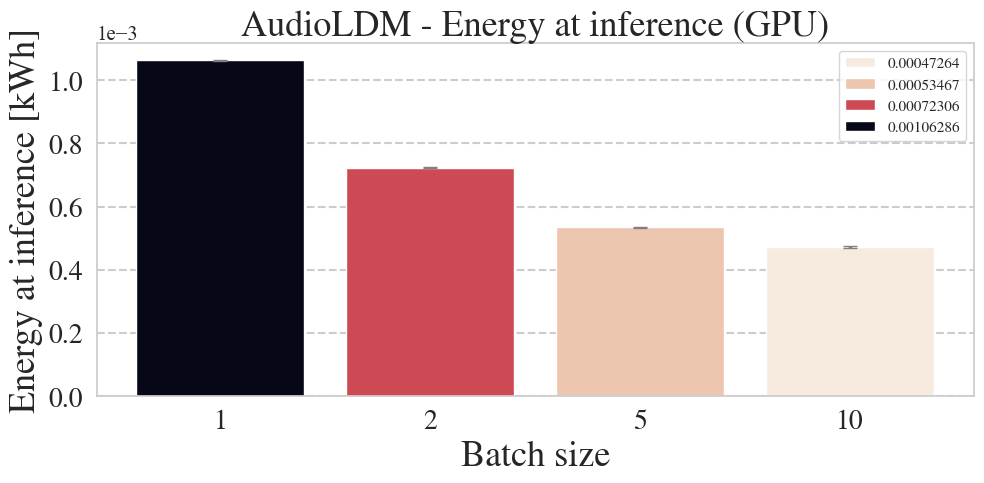

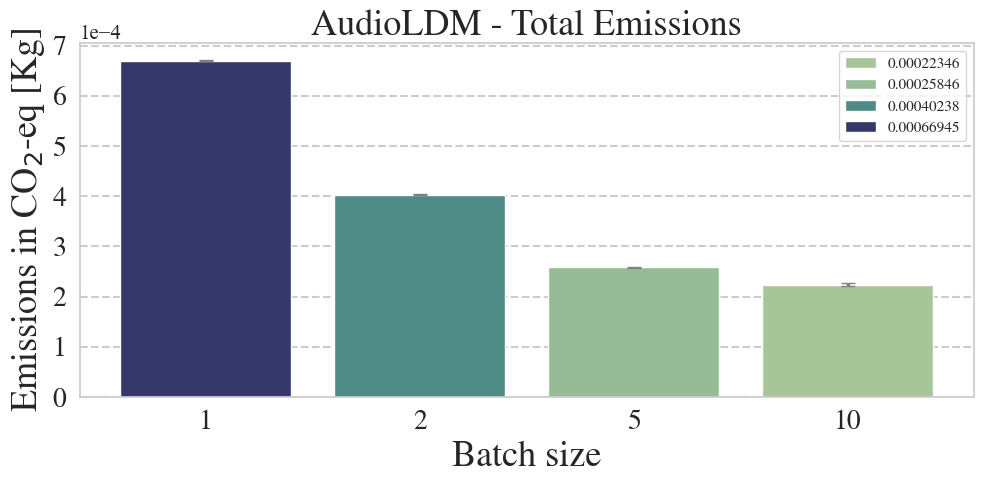

In [230]:
model_name = "AudioLDM" # model = "AudioLDM2" # model = "Make-an-Audio" # . . .

path = fr"{current_dir}\results\batch_size\{model_name}\\"
plot_batch_exp(model_name, compare=False)

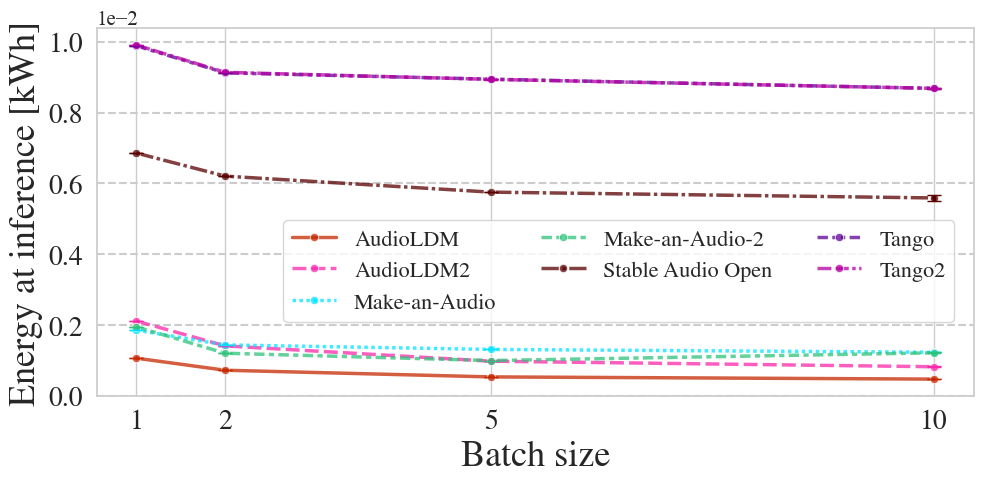

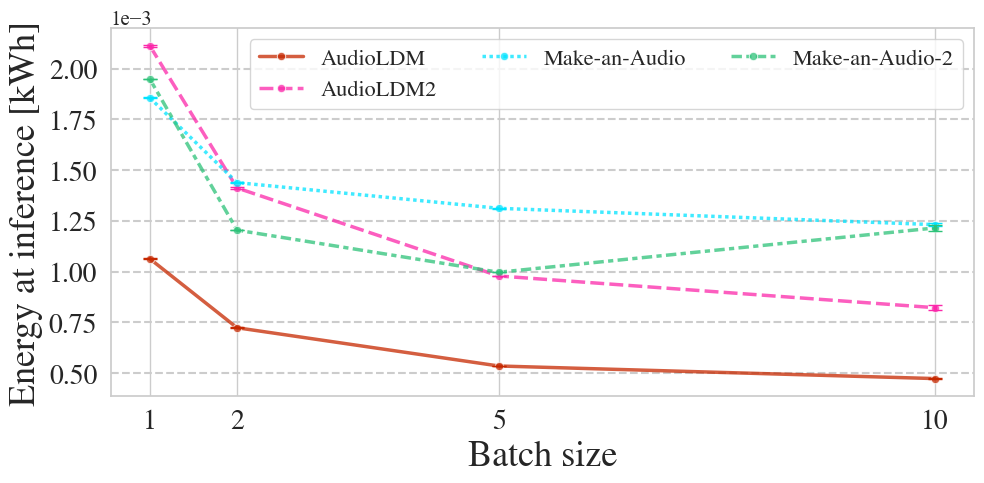

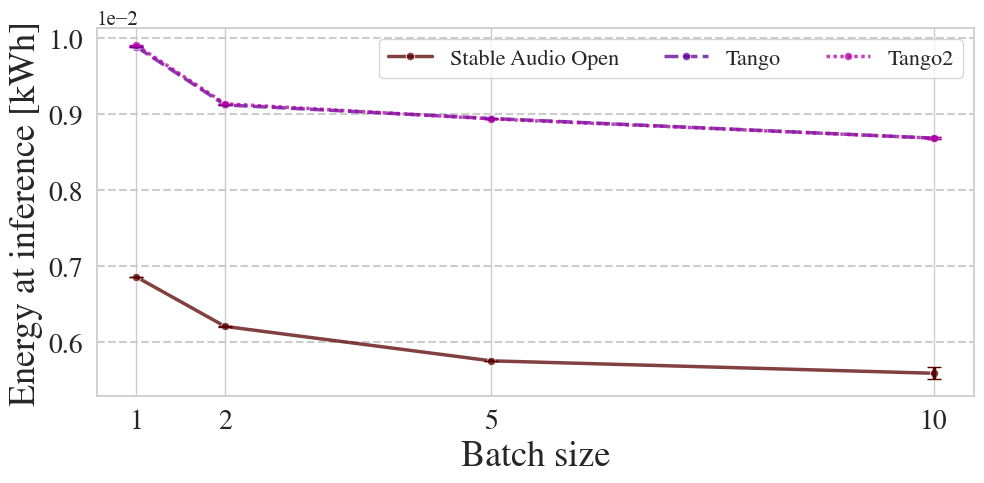

In [231]:
model_list = ["AudioLDM", "AudioLDM2", "Make-an-Audio", "Make-an-Audio-2", "Stable Audio Open",
              "Tango", "Tango2"]

models = [model_list, model_list[0:4], model_list[4:7]]

for lista in models:
    path_list = []
    for x in lista:
        # Define the local path for the model's emission data
        path = fr"{current_dir}\results\batch_size\{x}\\"
        path_list.append(path)
    plot_batch_exp(lista, compare=True)